In [1]:
ip = get_ipython()
ibe = ip.configurables[-1]
ibe.figure_formats = { 'pdf', 'png'}

In [2]:
%matplotlib inline

from pathlib import Path
from dot_pattern_decoder import DotPatternDecoder
from printer import Printer
from constants import Constants


decoder = DotPatternDecoder(Path.cwd().joinpath('../2020-04-08_22-00-09.jpg'))

decoder.get_position_codes(decoder.preprocess_image())

# Декодирование позиции

## Обработка изображения


В умных ручках используются инфракрасные камеры и прозрачные в этом спектре
чернила. За счет этого чернила не мешают позиционироваться на листах при письме.
Камера же делает снимки только тогда, когда на стержень оказывается давление.
Поэтому задача оцифровки рукописного текста и изображений в случае умных ручек
сводится к правильному декодированию последовательности таких снимков в координаты.


Первым этапом декодирования, после получения изображения, содержащего блок
минимального размера (8x8), является препроцессинг. **Исходное изображение (а)** 
переводится в **оттенки серого (б)**, а потом **бинаризуется (в)** (значение порога выведено 
эмпирически). Из получившегося изображения необходимо **удалить шумы (г)**, чтобы убрать 
артефакты печати и повысить качество распознавания. Для этого используется медианный 
фильтр (значение которого также выведено эмпирически).

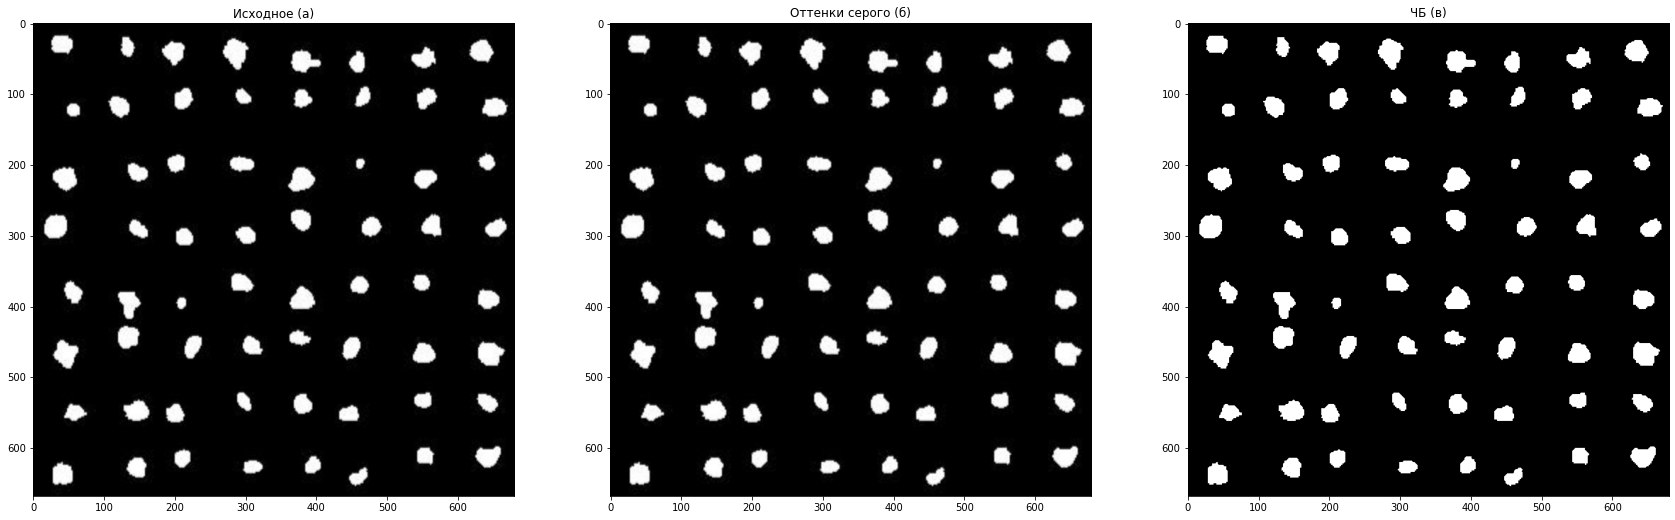

In [3]:
Printer.plot_images([
    (decoder.raw_image, 'Исходное (а)'), 
    (decoder.image_grayscale, 'Оттенки серого (б)'),
    (decoder.black_white_image, 'ЧБ (в)'),
])

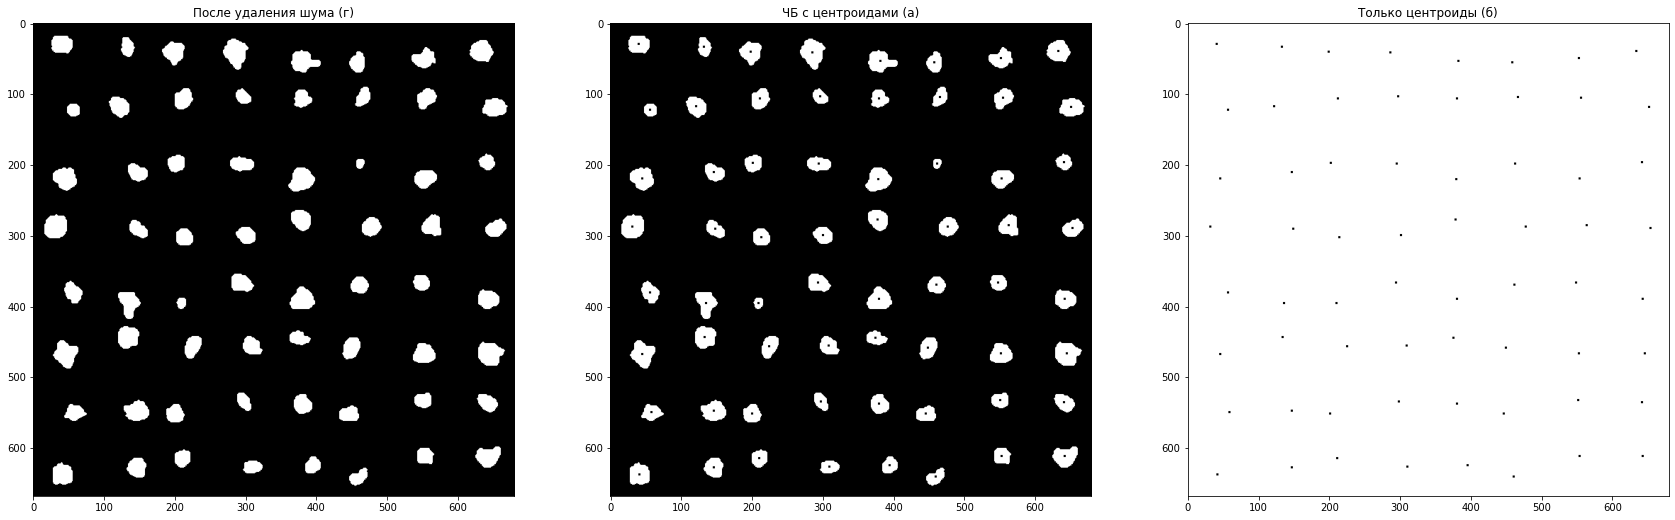

In [4]:
Printer.plot_images([
    (decoder.deleted_noise_image, 'После удаления шума (г)'),
    (decoder.deleted_noise_image_with_centroids, 'ЧБ с центроидами (а)'),
    (decoder.centroids_image, 'Только центроиды (б)')
])

Нужно отметить, что в данном изложении алгоритма используются относительно выровненные изрбражения.
Ручка же делает снимки под наклоном в силу того, что это происходит при письме. Причем важно учесть,
что угол наклона может варьироваться очень сильно, что делает позиционирование невозможным без
выравнивания изображения.

Точки исходного изображения представляются на бинаризованном изображении в виде областей белых пикселей.
С помощью инструмента regionprops из пакета skimage находим центроиды данных областей (**изображение (а)** показывает бинарное изображение с наложенными центроидами, а **изображение (б)** только центроиды). 

Важно отметить, что в случае неправильной фильтрации изображения, слишком низком пороге для бинаризации, некачественного исходного снимка, либо поврежденного бумажного носителя может возникнуть ситуация, когда возникнут лишние точки, либо пропадут нужные. В случае первых двух проблем нужно провести эксперименты для вычисления оптимальных параметров, а в случае других - попробовать поискать на изображении другой валидный блок, если таких нет, а коррекция ошибок не справляется - спозиционироваться невозможно.

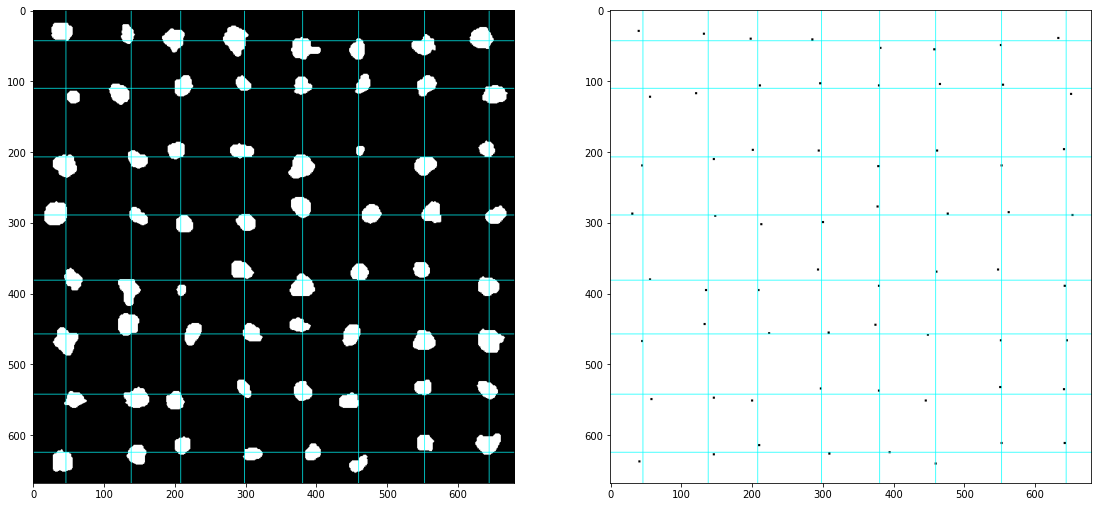

In [5]:
Printer.plot_images([
    (decoder.add_virtual_lines(
        decoder.deleted_noise_image, 
        decoder.direction_y.average, 
        decoder.direction_x.average), ''),
    (decoder.add_virtual_lines(
        decoder.centroids_image, 
        decoder.direction_y.average, 
        decoder.direction_x.average), '')
])

## Вычисление позиций точек

Координаты точек раскладываются в две таблицы - одна для координат X (Таблица 1), 
а вторая для координат Y (Таблица 2). 

In [6]:
print('Таблица 1. X-координаты точек')
Printer.print_table(decoder.direction_x.coordinates)

Таблица 1. X-координаты точек


29.67,122.40,219.04,287.22,380.05,467.06,549.82,637.08
33.52,117.59,210.70,290.89,395.48,443.22,547.65,627.49
40.92,106.78,197.75,302.05,395.05,456.43,551.41,614.41
41.58,103.70,198.68,299.35,366.78,455.74,534.08,626.55
53.96,106.44,220.95,277.37,389.92,444.64,537.94,624.27
55.35,104.13,198.01,287.36,369.77,458.47,551.79,640.86
49.90,105.88,219.32,285.96,366.23,466.66,532.51,611.01
39.31,118.95,196.15,289.46,389.71,466.76,535.77,611.94


In [7]:
print('Таблица 2. Y-координаты точек')
Printer.print_table(decoder.direction_y.coordinates)

Таблица 2. Y-координаты точек


40.22,56.66,45.02,31.64,56.19,45.73,58.50,41.08
132.84,121.53,146.90,148.06,135.07,133.72,146.23,146.34
198.48,211.69,201.86,213.11,209.13,224.98,200.06,210.52
285.45,296.02,294.12,300.42,293.56,308.43,297.33,309.39
381.35,379.53,378.42,377.97,379.62,374.99,379.91,394.29
457.70,465.44,461.14,476.83,460.38,448.80,445.66,459.16
551.40,554.45,552.79,562.61,547.73,551.32,550.11,552.64
632.30,650.87,640.22,652.66,641.74,644.25,640.77,641.95


В **Таблице 1** не просто так отмечены столбцы, а в **Таблице 2** - строки. Это связано с тем, как кодируется информация о положении в данном шаблоне. На что конкретно это влияет будет показано ниже, сейчас же достаточно знать, что позиция на листе закодирована таким образом: информация о столбце в координатах X, а о строке в координатах Y. 

In [8]:
print('Таблица 3. Некоторые параметры X-диапозонов')
Printer.print_x_params(
    decoder.direction_x.min, decoder.direction_x.max, 
    decoder.direction_x.difference, decoder.direction_x.average
)

Таблица 3. Некоторые параметры X-диапозонов


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7
min,29.6662,103.698,196.151,277.368,366.227,443.225,532.51,611.011
max,55.3538,122.396,220.955,302.049,395.484,467.056,551.787,640.864
diff,25.6876,18.6988,24.8033,24.6805,29.2577,23.831,19.2767,29.8527
avg,43.0272,110.733,207.574,289.957,381.624,457.371,542.621,624.201


In [9]:
print('Таблица 4. Некоторые параметры Y-диапозонов')
Printer.print_y_params(
    decoder.direction_y.min, decoder.direction_y.max, 
    decoder.direction_y.difference, decoder.direction_y.average
)

Таблица 4. Некоторые параметры Y-диапозонов


,min,max,diff,avg
y_0,31.6446,58.4969,26.8523,46.8805
y_1,121.531,148.061,26.5301,138.837
y_2,198.477,224.979,26.502,208.729
y_3,285.446,309.387,23.9414,298.089
y_4,374.991,394.29,19.2995,380.761
y_5,445.659,476.83,31.1709,459.387
y_6,547.727,562.615,14.8881,552.88
y_7,632.299,652.661,20.3619,643.096


### Позиции точек и коррекция ошибок распознавания


У точек есть 4 варианта смещения относительно номинальной позиции (пересечение вертикальной и горизонтальной линии). 

![img](img/image002.jpg)

Следовательно, каждая точка кодирует 2 бита информации. Один из битов для кодирования столбца (далее называется x бит), а второй - для строки (y бит).

In [10]:
Printer.print_named_rows(Constants.BITS_TABLE, ['x bit', 'y bit'])

,x bit,y bit
Left,1,0
Right,0,1
Up,0,0
Down,1,1


Из относительных положений внутри одного столбца точки можно разделить на 3 позиции: левая (L), средняя (M) и правая (R), в зависимости от того, в каком направлении смещена точка относительно оси X, либо оси Y. Обозначим эти позиици через { -1, 0, 1 } соответственно. По таблицу приведенной ниже видно, что позиции вверх/вниз и влево/вправо неразличимы при проекции на ось X и ось Y соответственно. 

In [11]:
Printer.print_named_rows(Constants.DIRECTIONS_TABLE, ['x bit', 'y bit'])

,x bit,y bit
Left,-1,0
Right,1,0
Up,0,1
Down,0,-1


В основном, в диапозонах есть точки всех типо, но в редких случаях там присутвуют точки только двух видов (L и M, либо M и R). Такой случай необходимо обрабатывать отдельно. Таким образом, все столбцы можно раздить на классы A и B. Для точек из класса А присваиваются коды, как было сказано выше. А для точек из класа B все так же, но расстояние между максимумом и минимумом делится на два интервала, а коды меняются { -2, 2 }. 

In [13]:
print('Таблица 5. Классы X-диапозонов')
Printer.print_named_rows(
    {'class': decoder.direction_x.classes}, 
    [f'x_{i}' for i in range(len(decoder.direction_x.classes))]
)
print()

print('Таблица 6. Классы Y-диапозонов')
Printer.print_named_rows(
    {'class': decoder.direction_y.classes}, 
    [f'y_{i}' for i in range(len(decoder.direction_y.classes))])

Таблица 5. Классы X-диапозонов


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7
class,A,B,A,A,A,A,B,A



Таблица 6. Классы Y-диапозонов


,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7
class,A,A,A,A,B,A,B,B


In [14]:
Printer.print_directions(decoder.x_codes, decoder.y_codes)

(-1 ; 1),(-1 ; 0),(0 ; 1),(0 ; 1),(1 ; 0),(1 ; 0),(1 ; 0),(0 ; 0)
(2 ; -1),(2 ; 1),(-2 ; 0),(-2 ; 0),(-2 ; 2),(-2 ; 0),(-2 ; 2),(2 ; -2)
(1 ; 0),(0 ; -1),(-1 ; 1),(-1 ; 0),(1 ; 0),(-1 ; 0),(1 ; 0),(-1 ; 0)
(0 ; 1),(0 ; -1),(1 ; 0),(1 ; 0),(-1 ; 0),(0 ; -1),(0 ; -1),(0 ; -1)
(0 ; -1),(1 ; 0),(1 ; 0),(-1 ; 0),(1 ; 0),(-1 ; 0),(-1 ; 0),(1 ; 0)
(1 ; 0),(-1 ; 0),(0 ; -1),(0 ; -1),(-1 ; 0),(0 ; 1),(1 ; 0),(1 ; -1)
(2 ; -1),(2 ; -1),(2 ; 1),(-2 ; 0),(-2 ; 2),(2 ; 1),(-2 ; 2),(-2 ; 2)
(1 ; 0),(0 ; -1),(-1 ; 0),(0 ; -1),(0 ; -1),(1 ; 0),(-1 ; 0),(-1 ; 0)


Для коррекции таблицы воспользуемся таблицей, приведенной ниже.

In [15]:
Printer.print_vertical_table([ 
        [ '-1/1' ,  '0'   ,     '-'      ,  '-'            ],
        [ '-1/1' , '-2/2' , 'sign(in_1)' ,  '0'            ],
        [ '0'    , '-2/2' ,    '0'       ,  'sign(in_2)'   ],
        [ '1/-1' , '-1/1' ,    'D'       ,  'D'            ],
        [ '0'    , '0'    ,    'D'       ,  'D'            ],
        [ '2/-2' , '-2/2' ,     '-'      ,  '-'            ]
    ], ['in 1', 'in 2', 'out 1', 'out 2']
)


decoder.correction_position_2(decoder.x_codes, decoder.y_codes)
decoder.correction_position_2(decoder.x_codes, decoder.x_codes)

in 1,in 2,out 1,out 2
-1/1,0,-,-
-1/1,-2/2,sign(in_1),0
0,-2/2,0,sign(in_2)
1/-1,-1/1,D,D
0,0,D,D
2/-2,-2/2,-,-


In [18]:
Printer.print_named_rows(Constants.DIRECTIONS_TABLE, ['x bit', 'y bit'])

,x bit,y bit
Left,-1,0
Right,1,0
Up,0,1
Down,0,-1


(-1 ; 1),(-1 ; 0),(0 ; 1),(0 ; 1),(1 ; 0),(1 ; 0),(1 ; 0),(0 ; 0)
(2 ; -1),(2 ; 1),(-2 ; 0),(-2 ; 0),(-2 ; 2),(-2 ; 0),(-2 ; 2),(2 ; -2)
(1 ; 0),(0 ; -1),(-1 ; 1),(-1 ; 0),(1 ; 0),(-1 ; 0),(1 ; 0),(-1 ; 0)
(0 ; 1),(0 ; -1),(1 ; 0),(1 ; 0),(-1 ; 0),(0 ; -1),(0 ; -1),(0 ; -1)
(0 ; -1),(1 ; 0),(1 ; 0),(-1 ; 0),(1 ; 0),(-1 ; 0),(-1 ; 0),(1 ; 0)
(1 ; 0),(-1 ; 0),(0 ; -1),(0 ; -1),(-1 ; 0),(0 ; 1),(1 ; 0),(1 ; -1)
(2 ; -1),(2 ; -1),(2 ; 1),(-2 ; 0),(-2 ; 2),(2 ; 1),(-2 ; 2),(-2 ; 2)
(1 ; 0),(0 ; -1),(-1 ; 0),(0 ; -1),(0 ; -1),(1 ; 0),(-1 ; 0),(-1 ; 0)


In [19]:
Printer.print_directions(decoder.x_codes, decoder.y_codes)

(-1 ; 1),(-1 ; 0),(0 ; 1),(0 ; 1),(1 ; 0),(1 ; 0),(1 ; 0),(0 ; 0)
(2 ; -1),(2 ; 1),(-2 ; 0),(-2 ; 0),(-2 ; 2),(-2 ; 0),(-2 ; 2),(2 ; -2)
(1 ; 0),(0 ; -1),(-1 ; 1),(-1 ; 0),(1 ; 0),(-1 ; 0),(1 ; 0),(-1 ; 0)
(0 ; 1),(0 ; -1),(1 ; 0),(1 ; 0),(-1 ; 0),(0 ; -1),(0 ; -1),(0 ; -1)
(0 ; -1),(1 ; 0),(1 ; 0),(-1 ; 0),(1 ; 0),(-1 ; 0),(-1 ; 0),(1 ; 0)
(1 ; 0),(-1 ; 0),(0 ; -1),(0 ; -1),(-1 ; 0),(0 ; 1),(1 ; 0),(1 ; -1)
(2 ; -1),(2 ; -1),(2 ; 1),(-2 ; 0),(-2 ; 2),(2 ; 1),(-2 ; 2),(-2 ; 2)
(1 ; 0),(0 ; -1),(-1 ; 0),(0 ; -1),(0 ; -1),(1 ; 0),(-1 ; 0),(-1 ; 0)


In [ ]:

# # print(line_x_coordinate)
# reconstructed_x_lines = reconstruct_line(x_codes_corrected, x_coordinates_of_centroids)
# reconstructed_y_lines = reconstruct_line(
#     y_codes_corrected.transpose(), 
#     y_coordinates_of_centroids.transpose()
# )


# display(tabulate.tabulate(
#     [['X'] + reconstructed_x_lines], [f'line {i}' for i in range(N)], tablefmt="html"
# ))

# display(tabulate.tabulate(
#     [['Y'] + reconstructed_y_lines], [f'line {i}' for i in range(N)], tablefmt="html"
# ))
# plot_images([
#     (add_virtual_lines(deleted_noise_image, reconstructed_x_lines, reconstructed_x_lines), ''),
#     (add_virtual_lines(centroids_image, reconstructed_x_lines, reconstructed_x_lines), '')
# ])